**Package imports and configuration parameters**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

conf = SparkConf().setAppName("QualitativeMultinomialModel").setMaster('local[*]')
context = SparkContext(conf=conf)
session = SparkSession(context)

**Load data into a RDD**

In [2]:
train_file = "./DATA/kddcup.data.10000.gz"
test_file = "./DATA/corrected.1000.gz"

train_data = context.textFile(train_file)
test_data  = context.textFile(test_file)
print(train_data.count())
print(test_data.count())
train_data.take(1)

10000
1000


['0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.']

**Splitting data in subgroups**

In [3]:
train_data_1, train_data_2 = train_data.randomSplit([7, 3], 10)
test_data_1, test_data_2 = test_data.randomSplit([1, 9], 12)
train_data = train_data_1.union(train_data_2)
test_data = test_data_1.union(test_data_2)

print(train_data.count())
print(test_data.count())
test_data.take(1)

10000
1000


['0,udp,private,SF,105,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,255,254,1.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,snmpgetattack.']

**Data preparation into [label, vector] tuples from the label field in the last column along with quantitative characteristics and the indexed and codified form of qualitative (categorical) characteristics.**

In [4]:
train_data_df = train_data.map(lambda x: x.split(',')).toDF()
test_data_df  = test_data.map(lambda x: x.split(',')).toDF()

train_data_df.head()

Row(_1='0', _2='tcp', _3='http', _4='SF', _5='215', _6='45076', _7='0', _8='0', _9='0', _10='0', _11='0', _12='1', _13='0', _14='0', _15='0', _16='0', _17='0', _18='0', _19='0', _20='0', _21='0', _22='0', _23='1', _24='1', _25='0.00', _26='0.00', _27='0.00', _28='0.00', _29='1.00', _30='0.00', _31='0.00', _32='0', _33='0', _34='0.00', _35='0.00', _36='0.00', _37='0.00', _38='0.00', _39='0.00', _40='0.00', _41='0.00', _42='normal.')

In [5]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import udf, monotonically_increasing_id
from pyspark.sql.types import ArrayType, DoubleType, IntegerType

train_cat_cols = train_data_df.select(train_data_df.columns[1:4])
test_cat_cols  = test_data_df.select(test_data_df.columns[1:4])

train_data_df = train_data_df.withColumn("id", monotonically_increasing_id()).drop(*train_data_df.columns[1:4])
test_data_df  = test_data_df.withColumn("id", monotonically_increasing_id()).drop(*test_data_df.columns[1:4])

label_column = train_data_df.columns[-1]
label_index  = train_data_df.columns.index(label_column) - 1

stages = [ StringIndexer(inputCol='_'+str(i+1), outputCol='ind'+str(i), handleInvalid='keep') for i in range(1, 4) ]
stages.append(OneHotEncoder(inputCols=[ 'ind'+str(i) for i in range(1,4) ], outputCols=[ 'cat'+str(i) for i in range(1,4) ], dropLast=False))
pipeline = Pipeline(stages=stages)
categorization_model = pipeline.fit(train_cat_cols)

col_mapping_udf = udf(lambda c: c.toArray().tolist(), returnType=ArrayType(DoubleType()))

In [6]:
def vectorize_categoric_columns(df, cols):
    dataframe = categorization_model.transform(df)
    for c in cols:
        dataframe = dataframe.withColumn(c, col_mapping_udf(c))
    return dataframe

cat_cols = [ 'cat' + str(i) for i in range(1, 4) ]
train_vect_cols = vectorize_categoric_columns(train_cat_cols, cat_cols).select(cat_cols)
test_vect_cols  = vectorize_categoric_columns(test_cat_cols,  cat_cols).select(cat_cols)

example_row = train_vect_cols.take(1)[0]
num_vals_col = [ len(col) for col in example_row ]

print(example_row)
print(num_vals_col)

Row(cat1=[1.0, 0.0, 0.0, 0.0], cat2=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], cat3=[1.0, 0.0, 0.0, 0.0, 0.0])
[4, 11, 5]


In [7]:
def split_vectorized_columns(df):
    vect_cols = []
    for i in range(len(num_vals_col)):
        lab = 'cat' + str(i + 1)
        vect_cols.append(df.select([ df[lab][j].cast(IntegerType()).alias(lab+'_'+str(j+1)) for j in range(num_vals_col[i]) ]))
    return vect_cols

train_vect_cols = split_vectorized_columns(train_vect_cols)
test_vect_cols  = split_vectorized_columns(test_vect_cols)

print(train_vect_cols)

[DataFrame[cat1_1: int, cat1_2: int, cat1_3: int, cat1_4: int], DataFrame[cat2_1: int, cat2_2: int, cat2_3: int, cat2_4: int, cat2_5: int, cat2_6: int, cat2_7: int, cat2_8: int, cat2_9: int, cat2_10: int, cat2_11: int], DataFrame[cat3_1: int, cat3_2: int, cat3_3: int, cat3_4: int, cat3_5: int]]


In [8]:
def merge_vectorized_cols_df(vect_cols_df):
    vect_cols = [ vcdf.withColumn('id', monotonically_increasing_id()) for vcdf in vect_cols_df ]
    for i in range(1, len(num_vals_col)):
        vect_cols[0] = vect_cols[0].join(vect_cols[i], 'id', 'outer')
    return vect_cols[0]

train_vect_df = merge_vectorized_cols_df(train_vect_cols)
test_vect_df  = merge_vectorized_cols_df(test_vect_cols)

print(train_vect_df)

DataFrame[id: bigint, cat1_1: int, cat1_2: int, cat1_3: int, cat1_4: int, cat2_1: int, cat2_2: int, cat2_3: int, cat2_4: int, cat2_5: int, cat2_6: int, cat2_7: int, cat2_8: int, cat2_9: int, cat2_10: int, cat2_11: int, cat3_1: int, cat3_2: int, cat3_3: int, cat3_4: int, cat3_5: int]


In [9]:
train_data_df = train_data_df.join(train_vect_df, 'id', 'outer').drop('id')
test_data_df  = test_data_df.join(test_vect_df, 'id', 'outer').drop('id')

print(train_data_df)

DataFrame[_1: string, _5: string, _6: string, _7: string, _8: string, _9: string, _10: string, _11: string, _12: string, _13: string, _14: string, _15: string, _16: string, _17: string, _18: string, _19: string, _20: string, _21: string, _22: string, _23: string, _24: string, _25: string, _26: string, _27: string, _28: string, _29: string, _30: string, _31: string, _32: string, _33: string, _34: string, _35: string, _36: string, _37: string, _38: string, _39: string, _40: string, _41: string, _42: string, cat1_1: int, cat1_2: int, cat1_3: int, cat1_4: int, cat2_1: int, cat2_2: int, cat2_3: int, cat2_4: int, cat2_5: int, cat2_6: int, cat2_7: int, cat2_8: int, cat2_9: int, cat2_10: int, cat2_11: int, cat3_1: int, cat3_2: int, cat3_3: int, cat3_4: int, cat3_5: int]


In [10]:
import numpy as np

def prepare_data(data):
    label = data[label_index]
    vector = np.array(data[: label_index] + data[label_index+1 :])
    return (label, vector)

tr_threat = train_data_df.rdd.map(prepare_data)
print(tr_threat.count())
print(tr_threat.take(1))

ts_threat = test_data_df.rdd.map(prepare_data)
print(ts_threat.count())
print(ts_threat.take(1))

10000
[('normal.', array(['0', '215', '45076', '0', '0', '0', '0', '0', '1', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '0.00', '0.00',
       '0.00', '0.00', '1.00', '0.00', '0.00', '0', '0', '0.00', '0.00',
       '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '1', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0'], dtype='<U21'))]
1000
[('snmpgetattack.', array(['0', '105', '146', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '2', '2', '0.00', '0.00',
       '0.00', '0.00', '1.00', '0.00', '0.00', '255', '254', '1.00',
       '0.01', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0', '1',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1',
       '1', '0', '0', '0', '0'], dtype='<U21'))]


**Descriptive statistics**

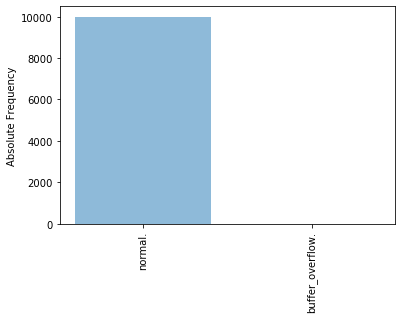

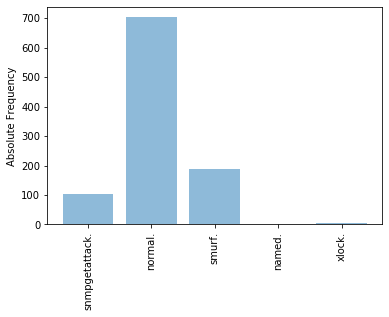

In [11]:
from operator import add

ltr_threat = tr_threat.map(lambda x: x[0])
tr_threat  = tr_threat.map(lambda x: x[1])

lts_threat = ts_threat.map(lambda x: x[0])
ts_threat  = ts_threat.map(lambda x: x[1])

def descriptive_statistics(labelled_threat):
    threat_count = labelled_threat.map(lambda lt: (lt, 1)).reduceByKey(add).collect()

    threat_labels = list(map(lambda x: x[0], threat_count))
    threat_values = list(map(lambda x: x[1], threat_count))
    y_pos = np.arange(len(threat_labels))

    plt.bar(y_pos, threat_values, align='center', alpha=0.5)
    plt.xticks(y_pos, threat_labels, rotation=90)
    plt.ylabel("Absolute Frequency")
    plt.show()

    return zip(threat_labels, threat_values)

labels = [ lab[0][: -1] for lab in descriptive_statistics(ltr_threat) ]

_ = descriptive_statistics(lts_threat)

**Scaling characteristics to mu=0 and delta=1**

In [12]:
from pyspark.mllib.feature import StandardScaler

std = StandardScaler(withMean=True, withStd=True)
model = std.fit(tr_threat)

std_tr_threat = model.transform(tr_threat)
std_ts_threat = model.transform(ts_threat)

print("Train:", std_tr_threat.take(1))
print("Test:",  std_ts_threat.take(1))

Train: [DenseVector([-0.0349, -0.198, 3.8659, 0.0, 0.0, -0.01, -0.0907, 0.0, 0.2504, -0.014, -0.0283, -0.0141, -0.0135, -0.0214, -0.0141, -0.0371, 0.0, 0.0, -0.1093, -0.7925, -0.8653, -0.0587, -0.0596, 0.0, 0.0, 0.0828, -0.0829, -0.4651, -1.1016, -2.5515, -5.1268, -0.2638, -0.4303, -0.5242, -0.1213, -0.1292, 0.0, 0.0, 0.2231, -0.1885, -0.1152, 0.0, 0.454, -0.3137, -0.1643, -0.1093, -0.105, -0.0995, -0.0898, -0.0869, -0.0609, -0.0575, 0.0, 0.0316, -0.0245, -0.0173, -0.01, 0.0])]
Test: [DenseVector([-0.0349, -0.3315, -0.398, 0.0, 0.0, -0.01, -0.0907, 0.0, -3.9934, -0.014, -0.0283, -0.0141, -0.0135, -0.0214, -0.0141, -0.0371, 0.0, 0.0, -0.1093, -0.6723, -0.7616, -0.0587, -0.0596, 0.0, 0.0, 0.0828, -0.0829, -0.4651, 1.4066, 0.5638, 0.3285, -0.1164, -0.4303, -0.5242, -0.1213, -0.1292, 0.0, 0.0, -4.4827, 5.3058, -0.1152, 0.0, -2.2025, -0.3137, -0.1643, -0.1093, -0.105, -0.0995, -0.0898, -0.0869, -0.0609, -0.0575, 0.0, 0.0316, -0.0245, -0.0173, -0.01, 0.0])]


**Preparation of multinomial labels**

In [13]:
from pyspark.mllib.regression import LabeledPoint

std_train_data = ltr_threat.zip(std_tr_threat)
std_test_data  = lts_threat.zip(std_ts_threat)

std_train_data.take(1)

[('normal.',
  DenseVector([-0.0349, -0.198, 3.8659, 0.0, 0.0, -0.01, -0.0907, 0.0, 0.2504, -0.014, -0.0283, -0.0141, -0.0135, -0.0214, -0.0141, -0.0371, 0.0, 0.0, -0.1093, -0.7925, -0.8653, -0.0587, -0.0596, 0.0, 0.0, 0.0828, -0.0829, -0.4651, -1.1016, -2.5515, -5.1268, -0.2638, -0.4303, -0.5242, -0.1213, -0.1292, 0.0, 0.0, 0.2231, -0.1885, -0.1152, 0.0, 0.454, -0.3137, -0.1643, -0.1093, -0.105, -0.0995, -0.0898, -0.0869, -0.0609, -0.0575, 0.0, 0.0316, -0.0245, -0.0173, -0.01, 0.0]))]

In [14]:
def prepare_multinomial_classifier_data(label, data_vector):
    attack = -1
    for l in labels:
        if l in label:
            attack = labels.index(l)
    
    return LabeledPoint(attack, data_vector)

train_data = std_train_data.map(lambda x: prepare_multinomial_classifier_data(x[0], x[1])).filter(lambda p: p.label >= 0)
test_data  = std_test_data.map(lambda x: prepare_multinomial_classifier_data(x[0], x[1])).filter(lambda p: p.label >= 0)

print(train_data.count())
print(train_data.take(20))

10000
[LabeledPoint(0.0, [-0.034868990958710405,-0.19803220930343068,3.8659241350435996,0.0,0.0,-0.01,-0.09066522725622918,0.0,0.25038567487959407,-0.013983654288806035,-0.028294176933755945,-0.014142842854277925,-0.01348451429961592,-0.021439818318327676,-0.014142842854277925,-0.03712073783854319,0.0,0.0,-0.1092689734600817,-0.7924850388604233,-0.8652529752378376,-0.058696891180846665,-0.05959745143042871,0.0,0.0,0.08278133964448649,-0.0829141719549872,-0.4651418763688911,-1.1016447409071428,-2.5515104669944364,-5.1268232004429475,-0.26379353774751146,-0.4302509585418046,-0.5241644391710493,-0.12133703729068722,-0.1291883996999241,0.0,0.0,0.22305510457435032,-0.18845350904108282,-0.11520659939046377,0.0,0.4539895517371291,-0.3137011887965562,-0.1643401100385565,-0.1092689734600817,-0.10497150703140372,-0.09947864498432611,-0.08979816076857786,-0.08692479160438635,-0.06093742254992414,-0.057537769885347055,0.0,0.03163701788887351,-0.024501024062435935,-0.017322240559621654,-0.01,0.0]),

**Descriptive statistics on the labelled points of data, having been scaled and mapped.**

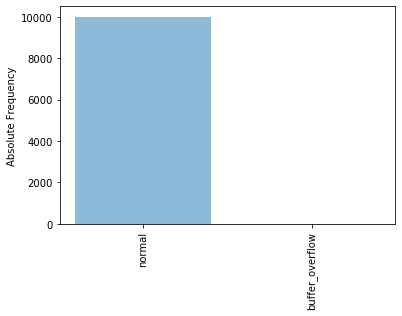

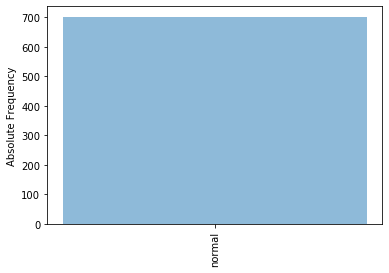

In [15]:
tr_threat  = train_data.map(lambda p: p.features)
ltr_threat = train_data.map(lambda p: labels[int(p.label)])

ts_threat  = test_data.map(lambda p: p.features)
lts_threat = test_data.map(lambda p: labels[int(p.label)])

_ = descriptive_statistics(ltr_threat)
_ = descriptive_statistics(lts_threat)

**Representation of the logistic function**

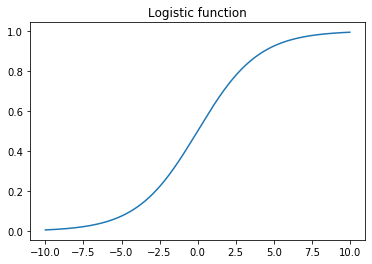

In [16]:
x = np.linspace(-10, 10, 1000)
plt.plot(x, 1 / (1 + np.exp(-0.5 * x)))
plt.title("Logistic function")
plt.show()

**Modelling**

In [17]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel

logistic_model = LogisticRegressionWithLBFGS.train(train_data, numClasses=len(labels), intercept=False)

print(logistic_model.weights)

[0.13982624301852764,0.04476319051081441,0.04075492572825943,0.0,0.0,9.910971820090552,0.13560708015722162,0.0,0.24896479720141662,830.5146093701392,0.1956646336977256,80.71710348490967,-904.3811296378548,-11.020469896357362,-0.06876876724084875,-0.09474516910106723,0.0,0.0,-0.057975206791312545,-0.20746239730557964,0.21586683490655117,-0.0881081974270737,0.1280174330386091,0.0,0.0,-0.6089734567290003,-0.5632337605925432,-0.028492575519701704,0.12418056707732893,-0.017542621037617622,0.08428413319709759,-0.09790831720806265,-0.04900352056352809,0.11007161531877865,0.14359229072563576,-0.3332456848460274,0.0,0.0,-0.06554899963950708,0.06035547746175633,0.025892724803410577,0.0,-0.04933816077646778,0.0006897702916871466,0.04270289219944748,-0.057975206791312545,0.07933678287890004,0.007535072444855905,0.046596845970901586,-0.03385931002270263,0.08877950623969658,0.0383920347107816,0.0,0.028862241425413174,-0.03038722875725534,0.024876289898408097,-0.05989743243342027,0.0]


**Evaluating the model**

In [18]:
label_and_prediction = test_data.map(lambda p: (p.label, logistic_model.predict(p.features)))

def count_OK_vs_KO(value):
    real_value = value[0]
    predicted_value = value[1]

    result = 'OK' if real_value == predicted_value else 'KO'
    return (result, 1)

results = label_and_prediction.map(count_OK_vs_KO).reduceByKey(add).collect()

print(results)

[('OK', 649), ('KO', 54)]


In [19]:
def compute_error(results):
    results_matrix = {}
    results_matrix[results[0][0]] = results[0][1]
    results_matrix[results[1][0]] = results[1][1]

    error = float(results_matrix['KO']) * 100 / (float(results_matrix['OK']) + float(results_matrix['KO']))
    return error

error = compute_error(results)
print("Error: {}%".format(error, 2))

Error: 7.681365576102418%


In [20]:
from shutil import rmtree

path = "./QualitativeMultinomialModel"

try:
    rmtree(path)
except:
    pass

logistic_model.save(context, path)

**Production-ready model**

In [21]:
logistic_model_prod = LogisticRegressionModel.load(context, path)

**Confusion matrix from the multinomial classifier**

In [22]:
def count_confusion(values):
    real_value = values[0]
    predicted_value = values[1]
    return (str(int(real_value)) + '_' + str(int(predicted_value)), 1)

classification_result = label_and_prediction.map(count_confusion).reduceByKey(add).collect()
classification_result = np.sort(np.reshape(classification_result, (len(classification_result), 2)), axis=0)
print(classification_result)

[['0_0' '54']
 ['0_1' '649']]


In [23]:
def compute_absolute_freq_matrix(classification):
    num_classes = len(labels)
    matrix = np.zeros((num_classes, num_classes), dtype=np.uint32)
    for result in classification:
        c = [ int(r) for r in result[0].split('_') ]
        matrix[c[0], c[1]] = result[1]
    return matrix

abs_freq_matrix = compute_absolute_freq_matrix(classification_result)
print(abs_freq_matrix)

[[ 54 649]
 [  0   0]]
